In [16]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn

# Utility functions

In [17]:
def exponential_decay(start, end, t):
    return start * (end / start) ** t
    
def linear_decay(start, end, t):
    return start + (end - start) * t    

In [18]:
def discretize(value, decimals=1):
    return round(value, decimals)

def get_discrete_state(state, decimals=1):
    if isinstance(state, np.ndarray):
        return tuple(discretize(s, decimals) for s in state)
    return discretize(state, decimals)

def get_discrete_action(action, decimals=1):
    if isinstance(action, np.ndarray):
        return tuple(discretize(a, decimals) for a in action)
    return discretize(action, decimals)

# Q-Learning with epsilon-greedy policy

In [34]:
def q_learning(env, num_episodes=1000, lr_start=0.1, lr_end=0.5, eps_start=0.5, eps_end=0.0, gamma=0.999):
    Q = {}
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Q-Learning"):
        state = get_discrete_state(env.reset())
        total_reward = 0
        done = False

        t = episode / num_episodes
        epsilon = linear_decay(eps_start, eps_end, t)
        learning_rate = linear_decay(lr_start, lr_end, t)

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = max(Q.get(state, {}), key=Q.get(state, {}).get, default=env.action_space.sample())

            next_state, reward, done, _ = env.step(action)
            next_state = get_discrete_state(next_state)

            Q.setdefault(state, {}).setdefault(action, 0)
            Q[state][action] += learning_rate * (reward + gamma * max(Q.get(next_state, {}).values(), default=0) - Q[state][action])

            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    return rewards

# DCEM with MLP

In [35]:
def deep_cross_entropy(env, num_episodes=1000, elite_frac=0.8, num_samples=200, 
                       max_iter=5000, depth=128, lr=0.01, device="cpu", dtype=torch.float32, goal=200):
    network = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], depth),
        nn.ReLU(),
        nn.Linear(depth, depth),
        nn.ReLU(),
        nn.Linear(depth, env.action_space.n)
    ).to(device)
    softmax = nn.Softmax(dim=1)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)

    def get_action(state, network):
        state = torch.FloatTensor(state).to(device)
        logits = network(state.unsqueeze(0))
        action_prob = softmax(logits).detach().cpu().numpy()[0]
        action = np.random.choice(len(action_prob), p=action_prob)
        return action

    def update_policy(network, elite_sessions):
        elite_states, elite_actions = [], []
        for session in elite_sessions:
            elite_states.extend(session['states'])
            elite_actions.extend(session['actions'])

        elite_states = torch.FloatTensor(elite_states).to(device)
        elite_actions = torch.LongTensor(elite_actions).to(device)

        optimizer.zero_grad()
        loss = loss_fn(network(elite_states), elite_actions)
        loss.backward()
        optimizer.step()

    def get_session(env, network, session_len=max_iter):
        states, actions = [], []
        total_reward = 0
        state = env.reset()

        for _ in range(session_len):
            states.append(state)
            action = get_action(state, network)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                break

        return {'states': states, 'actions': actions, 'total_reward': total_reward}

    def get_elite_sessions(sessions, q_param):
        total_rewards = np.array([session['total_reward'] for session in sessions])
        quantile = np.quantile(total_rewards, q_param)

        return [session for session in sessions if session['total_reward'] >= quantile]

    mean_rewards = []

    for epoch in range(num_episodes):
        sessions = [get_session(env, network) for _ in range(num_samples)]
        elite_sessions = get_elite_sessions(sessions, elite_frac)
        if len(elite_sessions) < 1:
            print(f"Epoch {epoch} skipped")
            continue
        update_policy(network, elite_sessions)

        mean_reward = np.mean([session['total_reward'] for session in elite_sessions])
        mean_rewards.append(mean_reward)
        print(f"Epoch {epoch}, Mean Reward: {mean_reward}")
        if len(mean_rewards)>5 and np.mean(mean_rewards[-5:]) >= goal:
            print("Converged!")
            break

    return mean_rewards + [mean_rewards[-1]] * (num_episodes - len(mean_rewards))

# Monte-Carlo with epsilon-greedy policy

In [36]:
def monte_carlo(env, num_episodes=1000, eps_start=1.0, eps_end=0.1, gamma=0.99999):
    qfunction = {}
    counter = {}
    total_rewards_per_episode = []

    for episode in tqdm(range(num_episodes), desc="Monte Carlo"):
        t = episode / num_episodes
        epsilon = exponential_decay(eps_start, eps_end, t)
    
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        state = get_discrete_state(env.reset())
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = max(qfunction.get(state, {}), key=qfunction.get(state, {}).get, default=env.action_space.sample())

            next_state, reward, done, _ = env.step(action)
            next_state = get_discrete_state(next_state)

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            total_reward += reward
            state = next_state

        total_rewards_per_episode.append(total_reward)

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]

            qfunction.setdefault(state, {}).setdefault(action, 0)
            counter.setdefault(state, {}).setdefault(action, 0)

            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards_per_episode

# SARSA with epsilon-greedy policy

In [43]:
def sarsa(env, num_episodes=1000, lr_start=0.1, lr_end=0.5, eps_start=0.5, eps_end=0.0, gamma=0.999):
    Q = {}
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Sarsa"):
        state = get_discrete_state(env.reset())
        total_reward = 0
        done = False

        t = episode / num_episodes
        epsilon = linear_decay(eps_start, eps_end, t)
        learning_rate = linear_decay(lr_start, lr_end, t)

        # Initial action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = max(Q.get(state, {}), key=Q.get(state, {}).get, default=get_discrete_action(env.action_space.sample()))

        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state = get_discrete_state(next_state)

            if np.random.rand() < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = max(Q.get(next_state, {}), key=Q.get(next_state, {}).get, 
                                  default=get_discrete_action(env.action_space.sample()))

            Q.setdefault(state, {}).setdefault(action, 0)
            Q[state][action] += learning_rate * (reward + gamma * Q.get(next_state, {}).get(next_action, 0) - Q[state][action])

            total_reward += reward
            state, action = next_state, next_action

        rewards.append(total_reward)

    return rewards

# Setup

In [44]:
env = gym.make('CartPole-v1')
num_episodes = 100000

# Training

In [45]:
deep_cross_entropy_rewards = deep_cross_entropy(env, num_episodes=num_episodes, goal=500)

Epoch 0, Mean Reward: 42.875
Epoch 1, Mean Reward: 58.825
Epoch 2, Mean Reward: 94.17073170731707
Epoch 3, Mean Reward: 92.58536585365853
Epoch 4, Mean Reward: 108.70731707317073
Epoch 5, Mean Reward: 126.25
Epoch 6, Mean Reward: 128.66666666666666
Epoch 7, Mean Reward: 151.825
Epoch 8, Mean Reward: 181.075
Epoch 9, Mean Reward: 208.625
Epoch 10, Mean Reward: 213.47619047619048
Epoch 11, Mean Reward: 332.0
Epoch 12, Mean Reward: 363.8
Epoch 13, Mean Reward: 470.5
Epoch 14, Mean Reward: 492.525
Epoch 15, Mean Reward: 491.175
Epoch 16, Mean Reward: 500.0
Epoch 17, Mean Reward: 500.0
Epoch 18, Mean Reward: 500.0
Epoch 19, Mean Reward: 500.0
Epoch 20, Mean Reward: 500.0
Converged!


In [46]:
q_learning_rewards = q_learning(env, num_episodes=num_episodes)

Q-Learning:   0%|          | 0/100000 [00:00<?, ?it/s]

In [47]:
monte_carlo_rewards = monte_carlo(env, num_episodes=num_episodes)

Monte Carlo:   0%|          | 0/100000 [00:00<?, ?it/s]

In [48]:
sarsa_rewards = sarsa(env, num_episodes=num_episodes)

Sarsa:   0%|          | 0/100000 [00:00<?, ?it/s]

# Results and plots

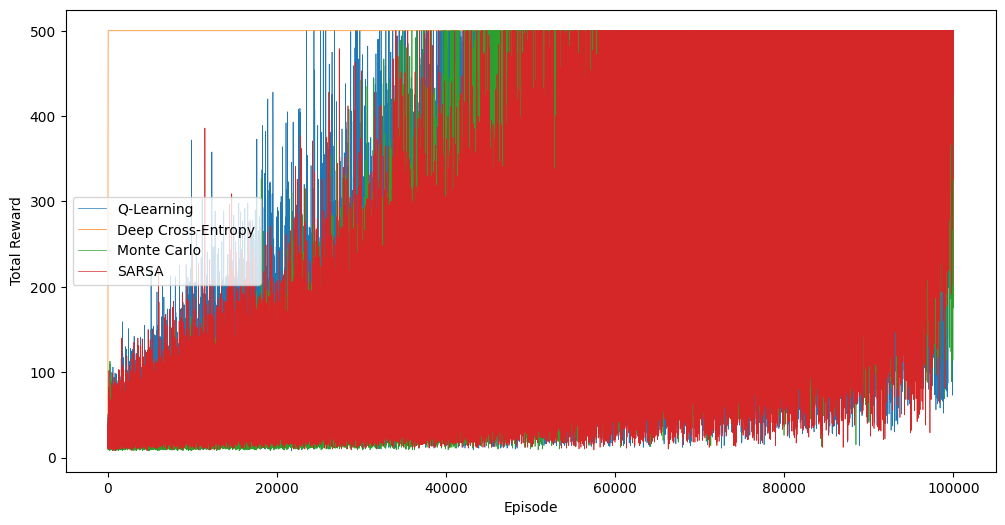

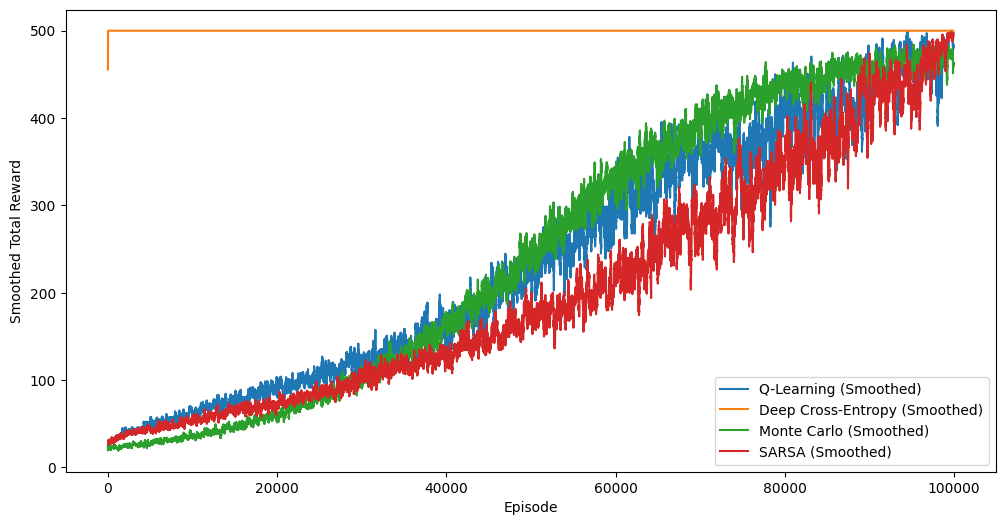

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(q_learning_rewards, label='Q-Learning', linewidth=0.5)
plt.plot(deep_cross_entropy_rewards, label='Deep Cross-Entropy', linewidth=0.5)
plt.plot(monte_carlo_rewards, label='Monte Carlo', linewidth=0.5)
plt.plot(sarsa_rewards, label='SARSA', linewidth=0.5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

window_size = 100

plt.figure(figsize=(12, 6))

smoothed_q_learning_rewards = np.convolve(q_learning_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_deep_cross_entropy_rewards = np.convolve(deep_cross_entropy_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_monte_carlo_rewards = np.convolve(monte_carlo_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_sarsa_rewards = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(smoothed_q_learning_rewards, label='Q-Learning (Smoothed)', linewidth=1.5)
plt.plot(smoothed_deep_cross_entropy_rewards, label='Deep Cross-Entropy (Smoothed)', linewidth=1.5)
plt.plot(smoothed_monte_carlo_rewards, label='Monte Carlo (Smoothed)', linewidth=1.5)
plt.plot(smoothed_sarsa_rewards, label='SARSA (Smoothed)', linewidth=1.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.legend()
plt.show()

# Analysis and Conclusion

DCEM converged for less than 20 * 200 = 4000 trajectories, while SARSA, Q-Learning and MonteCarlo require significantly more trajectories to converge. That is due to the fact that we discretize the state space very roughly, as well as the fact, that Q-Learning, SARSA and MonteCarlo algorithms are better suited for environments with discrete\tabular observation spaces.